<a href="https://colab.research.google.com/github/renaism/mcl-03-q-learning/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
import numpy as np
import seaborn as sns; sns.set()

## Grid Matrix

In [2]:
uploaded = files.upload()
for fn in uploaded.keys():
    G = np.loadtxt(fn, dtype=int)
print(G)

Saving DataTugas3ML2019.txt to DataTugas3ML2019 (3).txt
[[ -1  -2  -3  -2  -3  -3  -4  -1  -4  -2  -1  -2  -3  -3 500]
 [ -1  -3  -1  -2  -4  -1  -4  -1  -4  -2  -4  -2  -2  -2  -1]
 [ -4  -2  -1  -4  -2  -1  -2  -4  -2  -3  -2  -1  -2  -4  -4]
 [ -4  -2  -4  -1  -3  -2  -3  -2  -4  -2  -4  -1  -2  -4  -2]
 [ -4  -2  -2  -3  -2  -3  -1  -1  -4  -2  -1  -3  -4  -2  -4]
 [ -4  -3  -3  -4  -2  -3  -4  -2  -2  -1  -1  -2  -1  -2  -1]
 [ -2  -3  -2  -1  -1  -3  -2  -1  -4  -3  -1  -1  -2  -3  -3]
 [ -3  -1  -1  -4  -4  -3  -1  -2  -3  -1  -1  -4  -4  -3  -3]
 [ -3  -1  -4  -2  -3  -3  -1  -4  -4  -4  -2  -2  -2  -2  -1]
 [ -3  -4  -4  -2  -3  -4  -3  -3  -2  -2  -3  -4  -3  -4  -1]
 [ -3  -4  -1  -1  -1  -4  -4  -4  -4  -1  -2  -4  -2  -2  -1]
 [ -1  -3  -3  -3  -3  -3  -3  -3  -4  -1  -2  -4  -1  -2  -4]
 [ -2  -2  -1  -2  -2  -2  -4  -3  -1  -4  -1  -4  -2  -2  -2]
 [ -2  -1  -3  -1  -4  -4  -1  -3  -3  -1  -1  -2  -3  -4  -3]
 [ -2  -2  -1  -4  -4  -4  -2  -2  -3  -1  -2  -2  -1  -1  -3]

In [0]:
start = (14, 0)
goal = (0, 14)
A_N = 0
A_E = 1
A_S = 2
A_W = 3
actions = [A_N, A_E, A_S, A_W]

## Reward Matrix

In [0]:
R = np.full(G.shape+(len(actions),), -100, dtype=int)

for x in range(R.shape[0]):
    for y in range(R.shape[1]):
        # Action N / Up [0]
        if x > 0:
            R[x, y, 0] = G[x-1, y]
        # Action E / Right [1]
        if y < R.shape[1] - 1:
            R[x, y, 1] = G[x, y+1]
        # Action S / Down [2]
        if x < R.shape[0] - 1:
            R[x, y, 2] = G[x+1, y]
        # Action W / Left [3]
        if y > 0:
            R[x, y, 3] = G[x, y-1]

## Parameters

In [0]:
#@markdown ### Learning Rate (α)
α = 0.1 #@param {type:'number'}
#@markdown ### Discount (γ)
γ = 0.8 #@param {type:'number'}

## Next State
Function to determine next state based on current state and action

In [0]:
def next_state(G, s, a):
    if a == A_N:
        return (s[0]-1, s[1])
    elif a == A_E:
        return (s[0], s[1]+1)
    elif a == A_S:
        return (s[0]+1, s[1])
    elif a == A_W:
        return (s[0], s[1]-1)
    return s

## Q-value Function

In [0]:
def q_value(G, R, Q, s, a, α, γ):
    # Define next state based on action
    s_1 = next_state(G, s, a)
        
    # Find the maximum q-value for the next state
    q_1_max = np.amax(Q[s_1])
    
    return (1-α) * Q[s+(a,)] +  α * (R[s+(a,)] + γ*q_1_max)

## Learning

In [0]:
episode_length = 30 #@param {type:'integer'}
n_episode = 10000 #@param {type:'integer'}

## Valid Action
Determine valid actions based on state location in the grid. For example,  (0,14) state is on the bottom-left corner so the valid actions from that state are only up (N) and right (E)

In [0]:
def valid_action(G, s):
    if s[0] == 0 and s[1] == 0:
        return [A_E, A_S]
    elif s[0] == 0 and s[1] == G.shape[1]-1:
        return [A_S, A_W]
    elif s[0] == 0:
        return [A_E, A_S, A_W]
    elif s[0] == G.shape[0]-1 and s[1] == 0:
        return [A_N, A_E]
    elif s[0] == G.shape[0]-1 and s[1] == G.shape[1]-1:
        return [A_N, A_W]
    elif s[0] == G.shape[0]-1:
        return [A_N, A_E, A_W]
    elif s[1] == 0:
        return [A_N, A_E, A_S]
    elif s[1] == G.shape[1]-1:
        return [A_N, A_S, A_W]
    else:
        return [A_N, A_E, A_S, A_W]

## Fill the Q Matrix with randomized episodes

In [10]:
Q = np.full(R.shape, -100.0)
for n in range(n_episode):
    E = {'s': [], 'a': []}
    # Start episode from a random state
    s = (np.random.randint(G.shape[0]), np.random.randint(G.shape[1]))
    E['s'].append(s)
    # Generate next state with possible actions
    for _ in range(episode_length-1):
        a = np.random.choice(valid_action(G, s))
        s = next_state(G, s, a)
        E['s'].append(s)
        E['a'].append(a)
    for i in range(len(E['s'])-1):
        s = E['s'][i]
        a = E['a'][i]
        Q[s+(a,)] = q_value(G, R, Q, s, a, α, γ)
print(Q)

[[[-1.00000000e+02  6.37137641e+01  3.88649256e+01 -1.00000000e+02]
  [-1.00000000e+02  8.22026531e+01  4.94857719e+01  4.99164335e+01]
  [-1.00000000e+02  1.06638991e+02  6.57150256e+01  6.36827161e+01]
  [-1.00000000e+02  1.35940132e+02  8.35242518e+01  8.22181648e+01]
  [-1.00000000e+02  1.73776998e+02  1.07065083e+02  1.06643155e+02]
  [-1.00000000e+02  2.21090476e+02  1.38942930e+02  1.35937688e+02]
  [-1.00000000e+02  2.81593139e+02  1.74998508e+02  1.73758999e+02]
  [-1.00000000e+02  3.53531588e+02  2.24048500e+02  2.21014292e+02]
  [-1.00000000e+02  4.47194548e+02  2.80422360e+02  2.81544104e+02]
  [-1.00000000e+02  5.61577984e+02  3.55707249e+02  3.53594169e+02]
  [-1.00000000e+02  7.03274754e+02  4.45652568e+02  4.47202348e+02]
  [-1.00000000e+02  8.81647458e+02  5.62139473e+02  5.61575636e+02]
  [-1.00000000e+02  1.10587408e+03  7.05283515e+02  7.03257783e+02]
  [-1.00000000e+02  1.38615670e+03  8.84199766e+02  8.81639516e+02]
  [-1.00000000e+02 -1.00000000e+02  1.10782213e+

## Action Inverse
Function to determine the inverse of an action. For example, the inverse of up (N) action is down (S).

In [0]:
def action_inverse(a):
    if a == A_N:
        return A_S
    elif a == A_E:
        return A_W
    elif a == A_S:
        return A_N
    elif a == A_W:

        return A_E

## Find optimal policy
From the starting position, find a path that gives the most reward. The path is determined from the Q matrix.

Note: There can't be two concurrent actions that are inverse of each other. Action Inverse function will be used for this rule.

In [12]:
optimal_policy = []
s = start
reward = 0
length = 0
a = None
while s != goal:
    if length > 1000:
        break
    A = valid_action(G, s)
    if a != None:
        A.remove(action_inverse(a))
    sorted_A = np.argsort(Q[s])
    sorted_A = sorted_A[np.isin(sorted_A, A)]
    a = sorted_A[-1]
    print('State: {} | Value: {} | Next Action: {}'.format(s, G[s], a))
    reward += G[s]
    length += 1
    optimal_policy.append((s, a))
    s = next_state(G, s, a)
else:
    print('State: {} | Value: {}'.format(s, G[s]))
    reward += G[s]

print('\nTotal Reward: ', reward)
print('Path Length :', length)

State: (14, 0) | Value: -2 | Next Action: 1
State: (14, 1) | Value: -2 | Next Action: 0
State: (13, 1) | Value: -1 | Next Action: 0
State: (12, 1) | Value: -2 | Next Action: 1
State: (12, 2) | Value: -1 | Next Action: 0
State: (11, 2) | Value: -3 | Next Action: 0
State: (10, 2) | Value: -1 | Next Action: 1
State: (10, 3) | Value: -1 | Next Action: 1
State: (10, 4) | Value: -1 | Next Action: 0
State: (9, 4) | Value: -3 | Next Action: 0
State: (8, 4) | Value: -3 | Next Action: 1
State: (8, 5) | Value: -3 | Next Action: 1
State: (8, 6) | Value: -1 | Next Action: 0
State: (7, 6) | Value: -1 | Next Action: 0
State: (6, 6) | Value: -2 | Next Action: 1
State: (6, 7) | Value: -1 | Next Action: 0
State: (5, 7) | Value: -2 | Next Action: 1
State: (5, 8) | Value: -2 | Next Action: 1
State: (5, 9) | Value: -1 | Next Action: 1
State: (5, 10) | Value: -1 | Next Action: 0
State: (4, 10) | Value: -1 | Next Action: 1
State: (4, 11) | Value: -3 | Next Action: 0
State: (3, 11) | Value: -1 | Next Action: 

## Draw the optimal path to a heatmap

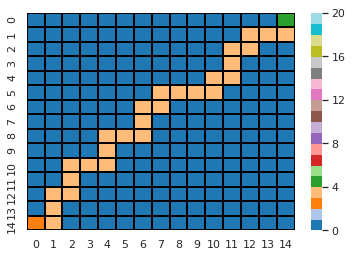

In [13]:
M = np.zeros(G.shape) # Map matrix

path = [x[0] for x in optimal_policy]

for i, p in enumerate(path):
    if i == 0:
        M[p] = 2
    else:
        M[p] = 3
M[goal] = 4

ax = sns.heatmap(M, vmax=20, cmap='tab20', linewidth=1, linecolor='black')